#Coffee Point Project: Aleksandra Graczyk
###Generating Data
###ABC Analysis
###FRM Analysis
###Automation Applications
* Inventory data
* Free samples
* Simulation

##Data Generation

In this section I am generating order data, customer data and inventory data and saving it to an Excel file, that can be easly downloaded. Having the Excel file ready to be modified and downloaded would be a desirable step in a real business situation.

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
np.random.seed(42)

# Product catalog with stable prices
product_catalog = {
    "Americano": 3.0,
    "Latte": 3.5,
    "Cappuccino": 4.0,
    "Tea": 2.5,
    "Croissant": 5.5,
    "Muffin": 4.5,
    "Juice": 3.5,
}

products = list(product_catalog.keys())
prices = list(product_catalog.values())

# I will generate 20,000 orders
num_orders = 20000

# Generate order details
order_data = []
for order_id in range(1, num_orders + 1):
    customer_id = np.random.randint(1000, 1600)  # I want to generate 600 unique customers
    date = np.random.choice(pd.date_range(start="2023-01-01", end="2024-01-01"))
    num_items = np.random.randint(1, 5)

    # Generate multiple products in a single order
    for _ in range(num_items):
        product = np.random.choice(products)
        quantity = np.random.randint(1, 4)  # Quantity for each product (1-3)
        price = product_catalog[product]
        amount = price * quantity
        order_data.append([order_id, customer_id, date, product, quantity, price, amount])

df_orders = pd.DataFrame(order_data, columns=["order_id", "customer_id", "date", "product", "quantity", "price", "amount"])

coffee_products = ["Americano", "Latte", "Cappuccino"]
df_orders["coffee_used_kg"] = df_orders.apply(
    lambda row: 0.01 * row["quantity"] if row["product"] in coffee_products else 0, axis=1
)

# Inventory data
inventory_data = {
    "product": ["Coffee Beans", "Tea", "Croissant", "Muffin", "Juice"],
    "category": ["Coffee", "Drink", "Food", "Food", "Drink"],
    "stock_kg_or_units": [60.0, 80.0, 70.0, 100.0, 250.0],  # coffe in kilograms, rest in units.
}
df_inventory = pd.DataFrame(inventory_data)



# Customer data
num_customers = 600
last_purchase_dates = df_orders.groupby("customer_id")["date"].max()

df_customers = pd.DataFrame({
    "customer_id": range(1000, 1000 + num_customers)
})

# Find last purchase date for each customer
df_customers = df_customers.merge(last_purchase_dates, on="customer_id", how="left")
df_customers.rename(columns={"date": "last_purchase"}, inplace=True)

# Export data to Excel
file_name = "CoffeePointData.xlsx"
with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
    df_orders.to_excel(writer, sheet_name="Order History", index=False)
    df_inventory.to_excel(writer, sheet_name="Inventory Info", index=False)
    df_customers.to_excel(writer, sheet_name="Customer Data", index=False)

print(f"Data has been generated and saved in: {file_name}")

Data has been generated and saved in: CoffeePointData.xlsx


## ABC Analysis

**ABC analysis** is a technique used in inventory management to categorize items based on their importance and value. It helps businesses prioritize their resources.

**A items** are the most important items. They require close monitoring, since they are used frequently. In my data those are items tha are the top 80% of sales.


In [4]:
# Group by product and calculate total sales
product_sales = df_orders.groupby("product")["amount"].sum().sort_values(ascending=False)

# Calculate cumulative percentage
cumulative_sales = product_sales.cumsum() / product_sales.sum() * 100

# Classify products into A, B, C categories
def classify_abc(cum_percentage):
    if cum_percentage <= 80:
        return "A"
    elif cum_percentage <= 95:
        return "B"
    else:
        return "C"

abc_categories = cumulative_sales.apply(classify_abc)

abc_analysis = pd.DataFrame({
    "Total Sales": product_sales,
    "Cumulative Percentage": cumulative_sales,
    "Category": abc_categories
})

print(abc_analysis)

            Total Sales  Cumulative Percentage Category
product                                                
Croissant       80360.5              21.228391        A
Muffin          65758.5              38.599453        A
Cappuccino      55696.0              53.312359        A
Juice           49273.0              66.328536        A
Latte           49231.0              79.333619        A
Americano       42378.0              90.528382        B
Tea             35855.0             100.000000        C


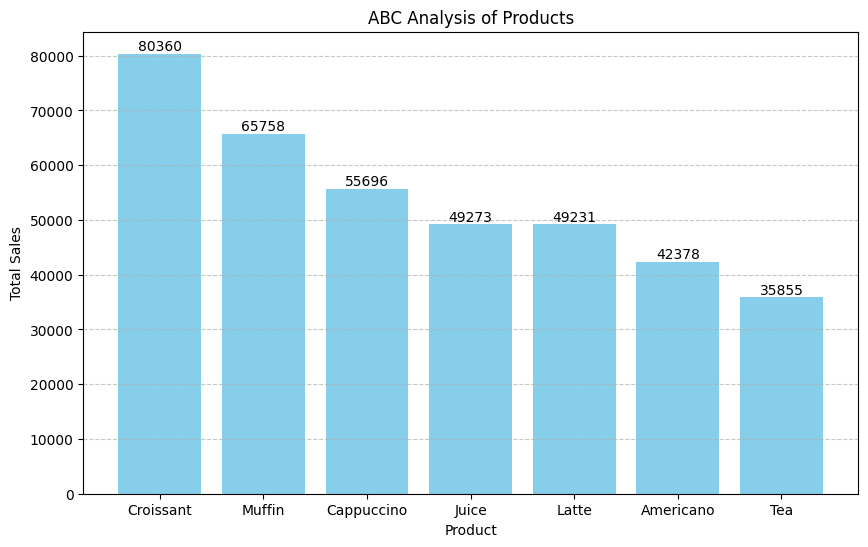

In [5]:
# Plot ABC Analysis
plt.figure(figsize=(10, 6))
plt.bar(product_sales.index, product_sales.values, color="skyblue")
for i, val in enumerate(product_sales):
    plt.text(i, val + 5, f"{val:.0f}", ha='center', va='bottom', fontsize=10)
plt.title("ABC Analysis of Products")
plt.xlabel("Product")
plt.ylabel("Total Sales")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#FRM Analysis

FRM analysis is a customer segmentation technique used to identify and group customers based on their purchasing behavior. It stands for:

- **Frequency**: How often a customer makes purchases.
- **Recency**: How recently a customer made a purchase.
- **Monetary**: How much money a customer spends on purchases.

Then a score for each customer is calculated and Excel file is updated with new sheet.

In [6]:
#Frequency: how many distinct orders each customer has placed
frequency = df_orders.groupby("customer_id")["order_id"].nunique()

#Recency
#latest day overall (from all orders)
latest_date = df_orders["date"].max()

#days since last purchase for each customer
recency = df_orders.groupby("customer_id")["date"].max().apply(lambda x: (latest_date - x).days)

# Monetary: monetary value of customer spend on purchasing products from the company
monetary = df_orders.groupby("customer_id")["amount"].sum()

df_frm = pd.DataFrame({
    "Frequency": frequency,
    "Recency": recency,
    "Monetary": monetary
})

#normalize the data to analyze the results
df_frm['Frequency_rank'] = df_frm['Frequency'].rank(ascending=False)
df_frm['Recency_rank'] = df_frm['Recency'].rank(ascending=False)
df_frm['Monetary_rank'] = df_frm['Monetary'].rank(ascending=False)

df_frm["Frequency_Norm"] = (df_frm["Frequency_rank"]/df_frm["Frequency_rank"].max())*100
df_frm["Recency_Norm"] = (df_frm["Recency_rank"]/df_frm["Recency_rank"].max())*100
df_frm["Monetary_Norm"] = (df_frm["Monetary_rank"]/df_frm["Monetary_rank"].max())*100

df_frm.drop(columns=["Frequency_rank", "Recency_rank", "Monetary_rank"], inplace=True)

#Calculating FRM Score (scale of 5)

df_frm["FRM_Score"] = 0.15*df_frm["Recency_Norm"] + 0.28*df_frm["Frequency_Norm"] + 0.57*df_frm["Monetary_Norm"]
df_frm['FRM_Score'] *= 0.05
df_frm['FRM_Score'] = df_frm['FRM_Score'].round(2)

df_frm["Customer_segment"] = np.where(df_frm['FRM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        df_frm['FRM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    df_frm['FRM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(df_frm['FRM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))


with pd.ExcelWriter(file_name, engine="openpyxl", mode="a") as writer:
    df_frm.to_excel(writer, sheet_name="FRM Analysis", index=True)

print(f"Data has been updated and saved in: {file_name}")

Data has been updated and saved in: CoffeePointData.xlsx


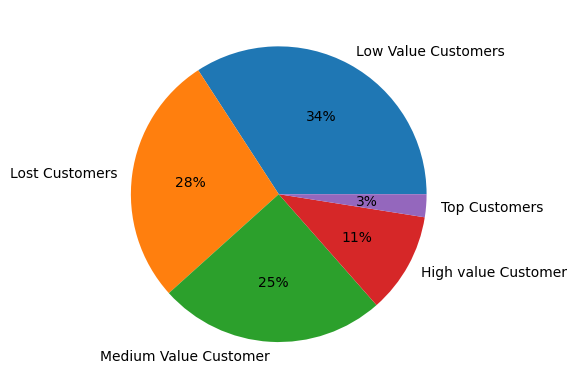

In [7]:
plt.pie(df_frm.Customer_segment.value_counts(),
        labels=df_frm.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

**Lost Customers** - are customers that have very small FRM_Score. They are not frequent at my coffe point, didn't leave a lot of money etc.

**Lost Customers and Low Value Customers** are a big part of my data - it is 62% total.

The coffe point should probably do something to make more customers stay.

##Application that allow to interact with data

###Check inventory status

The first application allows to see inventory data: thresholds and actual amount of the product in inventory. It also displays the message about the status.

(Run the cell again if dropdown is not visible or data didn't update.)

In [9]:
import ipywidgets as widgets
from IPython.display import display, HTML

In [24]:
# Dropdown for product selection
product_dropdown = widgets.Dropdown(
    options=df_inventory["product"].unique(),
    description="Select Product:",
    value = None
)

# Stock thresholds
stock_thresholds = {
    "Coffee Beans": 70,
    "Tea": 100,
    "Croissant": 100,
    "Muffin": 100,
    "Juice": 40
        }

output = widgets.Output()

def update_output(change):
    with output:
        output.clear_output()
        selected_product = change.new

        if selected_product is None:
            print("Please select a product.")
            return

        # Stock thresholds
        stock_thresholds = {
            "Coffee Beans": 70.0,
            "Tea": 100.0,
            "Croissant": 100.0,
            "Muffin": 100.0,
            "Juice": 40.0
        }

        # Get stock information
        stock_info = df_inventory.loc[df_inventory["product"] == selected_product, "stock_kg_or_units"]
        if stock_info.empty:
            print(f"Error: No stock data available for {selected_product}.")
            return

        stock = stock_info.values[0]
        threshold = stock_thresholds.get(selected_product, 0)

        print(f"Current stock of {selected_product}: {stock}")
        print(f"Threshold needs to be {threshold}")

        # Check if stock is below threshold
        if stock < threshold:
            display(HTML(f"<b style='color:red;'>In need of restock for {selected_product}!</b>"))
        else:
            display(HTML(f"<b style='color:green;'>Stock is sufficient for {selected_product}.</b>"))

# Attach observer to dropdown
product_dropdown.observe(update_output, names="value")

# Display widgets
display(product_dropdown, output)

Dropdown(description='Select Product:', options=('Coffee Beans', 'Tea', 'Croissant', 'Muffin', 'Juice'), value…

Output()

###See the customer "value" and make marketing decision

Imagine if marketing decided to bring more customers from lost and low value -> higher. They want each customer with that status to get a free sample.

This simulates the application that would write a message for a barista if they should offer a free sample of some goodie.

In [23]:
def process_new_order(customer_id, order_details=None):

    if customer_id in df_frm.index:  # Check if the customer exists in df_frm
        customer_segment = df_frm.loc[customer_id, "Customer_segment"]
        if customer_segment in ["Low Value Customers", "Lost Customers"]:
            message = (f"<b><font color='red'>Offer this customer a free sample!</font></b> "
                       f"(Customer segment: {customer_segment})")
        else:
            message = f"Customer segment: {customer_segment}"
    else:  # Handle new customer case
        message = "<b><font color='blue'>New customer.</font></b>"

    # Display the message
    display(widgets.HTML(value=message))

customer_id_input = widgets.IntText(description="Customer ID:")
submit_button = widgets.Button(description="Process Order")
output = widgets.Output()

def on_submit_button_clicked(_):
    with output:
        output.clear_output()
        if not customer_id_input.value:
            display(widgets.HTML(value="<b><font color='orange'>Please enter a valid Customer ID.</font></b>"))
            return
        process_new_order(customer_id_input.value)

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)

# Display the input and button widgets
display(widgets.VBox([customer_id_input, submit_button, output]))


##Automation application : simulation of entering a new order to a system

This is a simulation in which
* a new order, customer id and order details are added, simmilar what would happen in real life case
* a database (in my case Excel) is updated with all new details and calculations
* a message appears that tells if free sample should be offered
* there is a confirmation message, that Excel has been updated.

In real life, customer would collect their residence card and all this data could be updated by this action.

Results can be checked in updated Excel, but it takes a minute for the confirmation message to appear.

In [13]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display

In [22]:
# variables
product_catalog = {
    "Americano": 3.0,
    "Latte": 3.5,
    "Cappuccino": 4.0,
    "Tea": 2.5,
    "Croissant": 5.5,
    "Muffin": 4.5,
    "Juice": 3.5,
}

coffee_products = ["Americano", "Latte", "Cappuccino"]

file_name = "CoffeePointData.xlsx"
df_orders = pd.read_excel(file_name, sheet_name="Order History")
df_inventory = pd.read_excel(file_name, sheet_name="Inventory Info")
df_customers = pd.read_excel(file_name, sheet_name="Customer Data")
# -------------------

# Function to update the inventory
def update_inventory(new_order_data):
    global df_inventory
    for _, order in new_order_data.iterrows():
        product = order["product"]
        quantity = order["quantity"]
        if product in coffee_products:
            coffee_used = 0.01 * quantity
            df_inventory.loc[df_inventory["product"] == "Coffee Beans", "stock_kg_or_units"] -= coffee_used
        else:
            df_inventory.loc[df_inventory["product"] == product, "stock_kg_or_units"] -= quantity
    with pd.ExcelWriter(file_name, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        df_inventory.to_excel(writer, sheet_name="Inventory Info", index=False)
# -------------------

# Function to update customer data with new order
def update_customer_data(new_order_data):
    global df_customers
    global df_orders
    new_customer_id = customer_id_input.value
    last_purchase_date = new_order_data.loc[new_order_data["customer_id"] == new_customer_id, "date"].max()

    if new_customer_id in df_customers["customer_id"].values:
        df_customers.loc[df_customers["customer_id"] == new_customer_id, "last_purchase"] = last_purchase_date
    else:
        new_customer_row = pd.DataFrame({"customer_id": [new_customer_id], "last_purchase": [last_purchase_date]})
        df_customers = pd.concat([df_customers, new_customer_row], ignore_index=True)

    with pd.ExcelWriter(file_name, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        df_customers.to_excel(writer, sheet_name="Customer Data", index=False)
# -------------------
def recalculate_frm():
    global df_frm
    frequency = df_orders.groupby("customer_id")["order_id"].nunique()
    latest_date = df_orders["date"].max()
    recency = df_orders.groupby("customer_id")["date"].max().apply(lambda x: (latest_date - x).days)
    monetary = df_orders.groupby("customer_id")["amount"].sum()

    df_frm = pd.DataFrame({
        "Frequency": frequency,
        "Recency": recency,
        "Monetary": monetary
    })

    #normalize the data to analyze the results
    df_frm['Frequency_rank'] = df_frm['Frequency'].rank(ascending=False)
    df_frm['Recency_rank'] = df_frm['Recency'].rank(ascending=False)
    df_frm['Monetary_rank'] = df_frm['Monetary'].rank(ascending=False)

    df_frm["Frequency_Norm"] = (df_frm["Frequency_rank"]/df_frm["Frequency_rank"].max())*100
    df_frm["Recency_Norm"] = (df_frm["Recency_rank"]/df_frm["Recency_rank"].max())*100
    df_frm["Monetary_Norm"] = (df_frm["Monetary_rank"]/df_frm["Monetary_rank"].max())*100

    df_frm.drop(columns=["Frequency_rank", "Recency_rank", "Monetary_rank"], inplace=True)

    #Calculating FRM Score (scale of 5)
    df_frm["FRM_Score"] = 0.15*df_frm["Recency_Norm"] + 0.28*df_frm["Frequency_Norm"] + 0.57*df_frm["Monetary_Norm"]
    df_frm['FRM_Score'] *= 0.05
    df_frm['FRM_Score'] = df_frm['FRM_Score'].round(2)

    df_frm["Customer_segment"] = np.where(
        df_frm['FRM_Score'] > 4.5, "Top Customers",
        np.where(
            df_frm['FRM_Score'] > 4, "High value Customer",
            np.where(
                df_frm['FRM_Score'] > 3, "Medium Value Customer",
                np.where(df_frm['FRM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers')
            )
        )
    )

    # Overwrite the "FRM Analysis" sheet
    with pd.ExcelWriter(file_name, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        df_frm.to_excel(writer, sheet_name="FRM Analysis", index=True)

# -------------
def read_segment():
    customer_id = customer_id_input.value
    print("Customer id is: ", customer_id)
    if customer_id not in df_frm.index:
        print("Error: Customer not found in FRM data!")
        return

    customer_segment = df_frm.loc[customer_id, "Customer_segment"]
    if customer_segment in ["Low Value Customers", "Lost Customers"]:
        message = (f"<b><font color='red'>Offer this customer a free sample!</font></b> "
                   f"(Customer segment: {customer_segment})<br>"
                   f"All data has been updated in {file_name}")
    else:
        message = (f"Customer segment: {customer_segment}<br>"
                   f"All data has been updated in {file_name}")
    display(widgets.HTML(value=message))

# -------------


# Function to reset order ID and date for new order
def reset_order():
    global new_order_id
    global date

    new_order_id = df_orders['order_id'].max() + 1
    date = np.random.choice(pd.date_range(start="2023-01-01", end="2024-01-01"))

# -------------------

# Button for resetting the order
new_order_button = widgets.Button(description="New Order")

# Function to handle the new order button click
def new_order_button_click(button):
    reset_order()

    submit_button.disabled = False
    check_submit_button_visibility()


# Attach the reset functionality to the new order button
new_order_button.on_click(new_order_button_click)
# -------------------

def check_submit_button_visibility(change=None):
    # Check if customer ID is provided and at least one product is selected
    customer_id = customer_id_input.value
    selected_products = [dropdown.value for dropdown in product_dropdowns if dropdown.value is not None]

    # Enable or disable the "Submit" button based on the conditions
    if customer_id and selected_products:
        submit_button.disabled = False
    else:
        submit_button.disabled = True


# -------------------
# Initialize widgets
customer_id_input = widgets.IntText(description="Customer ID:")
product_dropdowns = [widgets.Dropdown(options=[None] + list(product_catalog.keys()), description=f"Item {i+1}:") for i in range(5)]
submit_button = widgets.Button(description="Submit New Order", disabled=True)
print("After submitting, wait for the confirmation message that Excel has been updated. This might take a minute.")
output = widgets.Output()
# -------------------

# Function to add items to the order
def add_items_to_order(button):
    with output:
        output.clear_output()
        customer_id = customer_id_input.value
        if not customer_id:
            print("Please enter a valid Customer ID.")
            return

        selected_products = [dropdown.value for dropdown in product_dropdowns if dropdown.value is not None]
        if not selected_products:
            print("No items selected. Please select at least one item.")
            return

        new_order_data = []
        for product in selected_products:
            price = product_catalog[product]
            quantity = 1
            amount = price * quantity
            coffee_used_kg = 0.01 if product in coffee_products else 0
            new_order_data.append([new_order_id, customer_id, date, product, quantity, price, amount, coffee_used_kg])

        df_new_order_items = pd.DataFrame(new_order_data, columns=["order_id", "customer_id", "date", "product", "quantity", "price", "amount", "coffee_used_kg"])
        global df_orders
        df_orders = pd.concat([df_orders, df_new_order_items], ignore_index=True)

        with pd.ExcelWriter(file_name, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
            df_orders.to_excel(writer, sheet_name="Order History", index=False)

        update_inventory(df_new_order_items)
        update_customer_data(df_new_order_items)
        recalculate_frm()
        read_segment()
# -------------------

# Attach the function to the submit button
submit_button.on_click(add_items_to_order)

# observe if button submit can be visible already
customer_id_input.observe(check_submit_button_visibility, names='value')
for dropdown in product_dropdowns:
    dropdown.observe(check_submit_button_visibility, names='value')

# Display all widgets
display(new_order_button, customer_id_input, *product_dropdowns, submit_button, output)

# Initial order setup
reset_order()

After submitting, wait for the confirmation message that Excel has been updated.


Button(description='New Order', style=ButtonStyle())

IntText(value=0, description='Customer ID:')

Dropdown(description='Item 1:', options=(None, 'Americano', 'Latte', 'Cappuccino', 'Tea', 'Croissant', 'Muffin…

Dropdown(description='Item 2:', options=(None, 'Americano', 'Latte', 'Cappuccino', 'Tea', 'Croissant', 'Muffin…

Dropdown(description='Item 3:', options=(None, 'Americano', 'Latte', 'Cappuccino', 'Tea', 'Croissant', 'Muffin…

Dropdown(description='Item 4:', options=(None, 'Americano', 'Latte', 'Cappuccino', 'Tea', 'Croissant', 'Muffin…

Dropdown(description='Item 5:', options=(None, 'Americano', 'Latte', 'Cappuccino', 'Tea', 'Croissant', 'Muffin…

Button(description='Submit New Order', disabled=True, style=ButtonStyle())

Output()

Now, after entering new order data, all previous functionalities, like checking the inventory or making a plot work as well, with new data included.